In [ ]:
'''

There is an issue with the textures as described in README. Sometimes when exporting to OBJ only one gray scale texture is passed.
Alternative could be to generate colors so that there is not gray scale. 
I started working on that but nothing useful came up.
'''

In [64]:
from pygltflib import GLTF2, Scene
import trimesh

from pytorch3d.io import load_obj, load_ply
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    FoVOrthographicCameras,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    BlendParams,
    TexturesVertex,
    TexturesAtlas,
    PointsRenderer,
    HardPhongShader,
    PointsRasterizationSettings,
     PointLights,
    PointsRasterizer,
    SoftSilhouetteShader
)



from pyrender import Mesh


from pytorch3d.io import IO
from pytorch3d.io.experimental_gltf_io import MeshGlbFormat


from pytorch3d.structures import Meshes

import sys
sys.path.append("../")
from rendererClass import RendererClass

import matplotlib.pyplot as plt
import json
import itertools
import torch
import numpy as np

In [65]:
param_path = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/params_inference.json"
with open(param_path) as f:
    params = json.load(f)

device = "cuda:0"


all_dist = params["camera_dist"]
all_elev = params["elevation"]
all_azim = params["azim_angle"]

#get all combinations
all_combs =  list(itertools.product(*[all_dist,all_elev,all_azim]))
comb = all_combs[0]

# Default with gray scale

In [80]:
filename = "/home/andstasi/Projects/MediaVerse/3D_to_2D_converter/pytorch3d-renderer/data/random_example/Bed/PLY_to_OBJ.obj"
Renderer_class  = RendererClass(params)
'''
try:
    verts, faces, aux = load_obj(
                filename,
                device=device,
                load_textures=True,
                create_texture_atlas=True,
                texture_atlas_size=4,
                texture_wrap="repeat"
                )
except:'''
verts, faces, aux = load_obj(
            filename,
            device=device,
            load_textures=True)

In [81]:
verts = verts.to(device)
faces_idx = faces.verts_idx.to(device) #get ids from the faces for back projecting

# normalize and center the mesh
verts = Renderer_class.pre_process(verts)
    
# ------ Create a textured object -----------
atlas = aux.texture_atlas



normalize the input in a unit shpere


In [82]:
# Create Meshes object
mesh = Meshes(
    verts=[verts],
    faces=[faces_idx]) 

In [83]:
color = torch.ones(1, verts.size(0), 3, device=device)
mesh.textures = TexturesVertex(verts_features=color)

In [84]:
dist,elev,azim = 1,0,45
image_size = 1024
blend_params = BlendParams(sigma=0.001, gamma=0.001)

R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
raster_settings = RasterizationSettings(
    image_size=image_size,
    blur_radius=0.0,
    clip_barycentric_coords=True,
    faces_per_pixel=1,
)
# Initialize rasterizer by using a MeshRasterizer class
rasterizer = MeshRasterizer(
    cameras=cameras,
    raster_settings=raster_settings
)
# The textured phong shader interpolates the texture uv coordinates for
# each vertex, and samples from a texture image.
shader = HardPhongShader(device=device, cameras=cameras,lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]]))
#shader = SoftSilhouetteShader(blend_params)

# Create a mesh renderer by composing a rasterizer and a shader
renderer = MeshRenderer(rasterizer, shader)

In [87]:
image = renderer(mesh)[0, ..., :3].cpu().numpy()

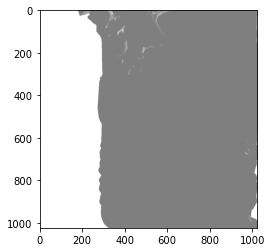

In [88]:
plt.imshow(image)
plt.show()